# Section 5.3: Recurrent neural nets: echo-state networks (ESNs)

This page contains simulations in Section 5.3.

## Contents

    - Memory curve for block Haar $W$
    - Illustration of $\mathcal{R}$ for non-symmetric and (Wigner) symmetric Gaussian $W$
    - FUNCTIONS


## Memory curve for block Haar $W$


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.linalg

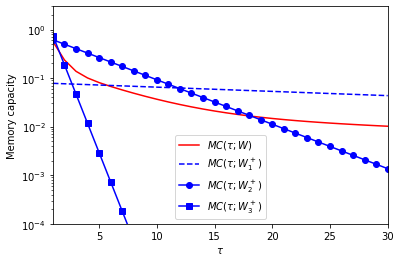

In [4]:
c = .75
c1 = 0.01
alpha1 = 0.99
c2 = 0.1
alpha2 = 0.9
c3 = 0.89
alpha3 = 0.5

taus = np.linspace(1,30,30)
MC_multip = ( c1*alpha1**(2*taus) + c2*alpha2**(2*taus) + c3*alpha3**(2*taus) )/( c1/(1-alpha1**2) + c2/(1-alpha2**2) + c3/(1-alpha3**2) )/(1-c)
MC1 = ( alpha1**(2*taus)*(1-alpha1**2) )/(1-c)
MC2 = ( alpha2**(2*taus)*(1-alpha2**2) )/(1-c)
MC3 = ( alpha3**(2*taus)*(1-alpha3**2) )/(1-c)


plt.semilogy(taus, MC_multip, 'r',label=r'$MC(\tau;W)$')
plt.semilogy(taus, MC1, 'b--',label=r'$MC(\tau;W_1^+)$')
plt.semilogy(taus, MC2, 'bo-',label=r'$MC(\tau;W_2^+)$')
plt.semilogy(taus, MC3, 'bs-',label=r'$MC(\tau;W_3^+)$')
plt.gca().set_xlim([1,30])
plt.gca().set_ylim([1e-4,3])
plt.xlabel(r'$\tau$')
plt.ylabel(r'Memory capacity')
_ = plt.legend()

## Illustration of $\mathcal{R}$ for non-symmetric and (Wigner) symmetric Gaussian $W$


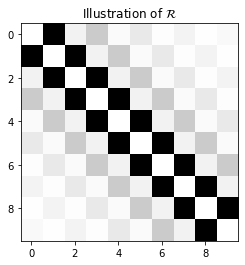

In [14]:
choice_W = 'Wigner' # 'iid', 'Wigner', 'Haar'
alpha = 0.9
n = 200
T = 400

if choice_W == 'iid':
    W = np.random.randn(n,n)/np.sqrt(n)
    W = W/np.abs(scipy.sparse.linalg.eigs(W,1)[0])
    W = alpha*W

if choice_W == 'Wigner':
    W = np.random.randn(n,n)/np.sqrt(n)
    W = np.triu(W,1)+np.tril(W.T,-1)+np.diag(np.random.randn(n)/np.sqrt(n))
    W = W/np.abs(scipy.sparse.linalg.eigs(W,1)[0])
    W = alpha*W

if choice_W == 'Haar':
    W = np.random.randn(n)/np.sqrt(n)
    W = np.linalg.solve(scipy.linalg.sqrtm(W@W.T),W)
    W = alpha*W

pW = np.zeros((n,n,T))
pW[:,:,0]=np.eye(n)

pWW = np.zeros((n,n,T))
pWW[:,:,0]=np.eye(n)

for i in range(1,T):
    pW[:,:,i]=W@pW[:,:,i-1]
    pWW[:,:,i]=W@pWW[:,:,i-1]@W.T

sumpWW = np.sum(pWW,2)

S=np.zeros((n,n,T))
for i in range(1,T):
    S[:,:,i]=sumpWW@(pW[:,:,i].T)

start_R =n/T/np.abs(1-n/T)*np.eye(T)
start_tR=np.abs(1-n/T)*sumpWW
R,tR = computeR(n,T,S,start_R,start_tR)

plt.imshow(1-R[0:10,0:10],cmap='gray')
plt.title(r'Illustration of $\mathcal{R}$')
_ = plt.show()

## FUNCTIONS

In [7]:
def computeR(n,T,S,start_R,start_tR):

    if n<T:
        dIn=0
        dIT=np.eye(T)
    else:
        dIn=np.eye(n)
        dIT=0

    Rtmp  = np.zeros((T,T))

    R = start_R
    tR= start_tR

    while np.max(np.abs((R-Rtmp)))>1e-15:
        Rtmp=R

        invtR = np.linalg.inv(dIn+tR)
        r=np.zeros(T)
        for q in range(T):
            r[q]=1/n*np.trace(S[:,:,q]@invtR)

        R = n/T*scipy.linalg.toeplitz(r)

        inv_I_R = np.linalg.inv(dIT+R)
        tR = 1/T*np.trace(inv_I_R)*S[:,:,0]
        for q in range(1,T):
            tR = tR + 1/T*np.sum(np.diag(inv_I_R,q-1))*(S[:,:,q]+S[:,:,q].T)

    return R,tR